In [1]:
import load
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# dataset = load.load_consumption_csv('./data/energy-consumption-us/merged_3yr.csv')
# dataset = load.load_consumption_csv('./data/energy-consumption-us/mini.csv')
dataset = load.load_consumption_csv('./data/energy-consumption-us/super-mini.csv')

In [3]:
dataset[:5]

[{'datetime_beginning_utc': Timestamp('2021-01-01 05:00:00'),
  'datetime_beginning_ept': Timestamp('2021-01-01 00:00:00'),
  'nerc_region': 'RFC',
  'mkt_region': 'MIDATL',
  'zone': 'DPL',
  'load_area': 'DPLCO',
  'mw': 1942.835,
  'is_verified': True},
 {'datetime_beginning_utc': Timestamp('2021-01-01 06:00:00'),
  'datetime_beginning_ept': Timestamp('2021-01-01 01:00:00'),
  'nerc_region': 'RFC',
  'mkt_region': 'MIDATL',
  'zone': 'DPL',
  'load_area': 'DPLCO',
  'mw': 1910.698,
  'is_verified': True},
 {'datetime_beginning_utc': Timestamp('2021-01-01 07:00:00'),
  'datetime_beginning_ept': Timestamp('2021-01-01 02:00:00'),
  'nerc_region': 'RFC',
  'mkt_region': 'MIDATL',
  'zone': 'DPL',
  'load_area': 'DPLCO',
  'mw': 1901.483,
  'is_verified': True},
 {'datetime_beginning_utc': Timestamp('2021-01-01 08:00:00'),
  'datetime_beginning_ept': Timestamp('2021-01-01 03:00:00'),
  'nerc_region': 'RFC',
  'mkt_region': 'MIDATL',
  'zone': 'DPL',
  'load_area': 'DPLCO',
  'mw': 1921.4

In [4]:
volume_by_timestamp = []

for row in dataset:
    ts = row['datetime_beginning_ept'] 
    volume_by_timestamp.append((ts, row['mw']))
    
volume_by_timestamp.sort(key=lambda tup: tup[0])

## Plot the data

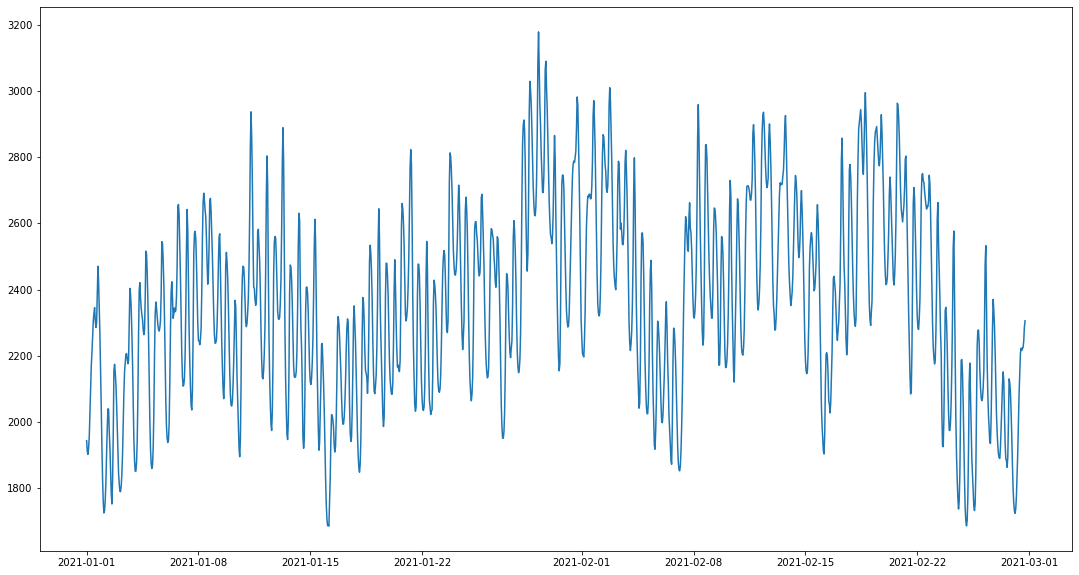

In [5]:
x, y = zip(*volume_by_timestamp)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y)

## Mark Mondays

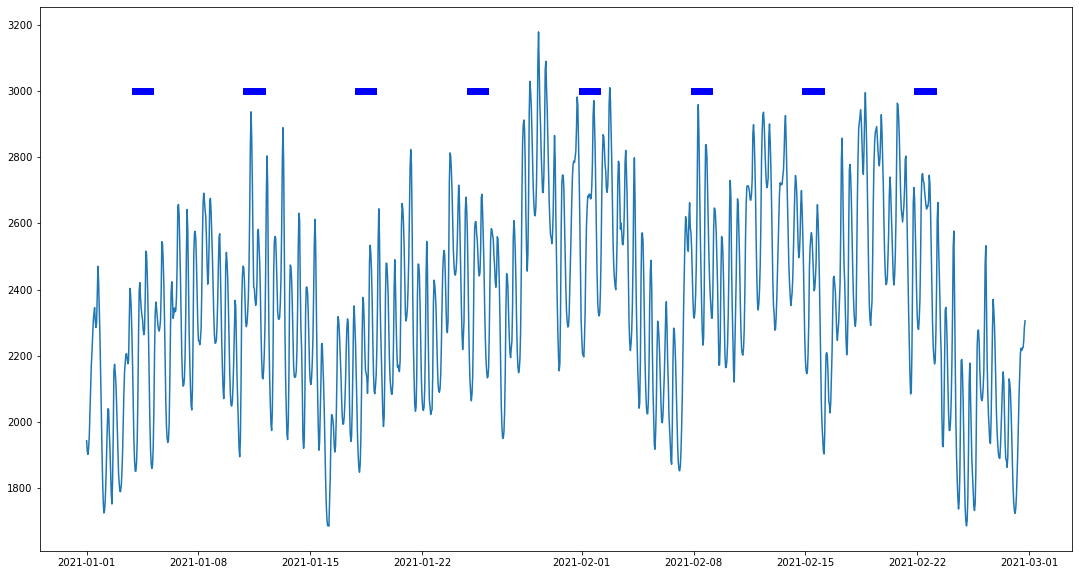

In [6]:
x_zoomed, y_zoomed = zip(*(volume_by_timestamp))

## (Monday).weekday == 0
y_2_zoomed = [3000 if ts.weekday() == 0 else None for ts in x_zoomed]


fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x_zoomed, y_zoomed)
_ = ax.plot(x_zoomed, y_2_zoomed, 'bs')

## Histogram

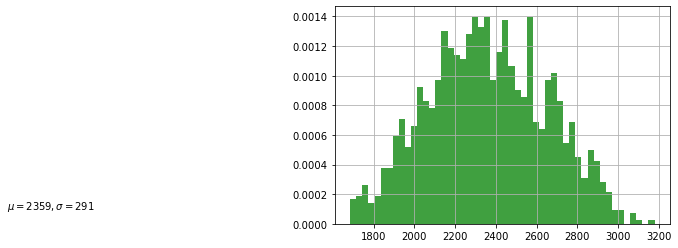

In [7]:
n, bins, patches = plt.hist(y, 50, density=True, facecolor='g', alpha=0.75)

mu = np.mean(y)
std = np.std(np.array(y))

plt.text(0, 0.0001, "$\mu=$"+str(round(mu))+'$,\sigma=$'+str(round(std)))
plt.grid(True)

## Stationarity

The diagram looks somewhat stationary, but lets do adf test. 

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

(adf_stat, p_value, _, _, critical_values, _, ) = adfuller(y)
print('ADF Statistic: %f' % adf_stat)
print('p-value: %f' % p_value)
print("Critical value %%1: %f" % critical_values['1%'])
    
if p_value < 0.05 and adf_stat < critical_values['1%']:
    print("Time series is stationary")

ADF Statistic: -5.060104
p-value: 0.000017
Critical value %1: -3.435077
Time series is stationary


## Make up some features

* Day of week
* Month of year 
* Time of day

In [9]:
import math

day_of_week = np.array([ts.weekday() for ts in x])
month = np.array([ts.month - 1 for ts in x]) # smh Jan is 1 - shift it down
time_of_day = np.array([math.floor(ts.hour / 4) for ts in x])  # split day into 6 periods

### Check how balanced are the values

In [10]:
print(np.bincount(day_of_week))
print(np.bincount(month))
print(np.bincount(time_of_day))


[192 192 192 192 216 216 211]
[744 667]
[236 236 236 236 235 232]


## Fit trend line

In [11]:
from sklearn.linear_model import LinearRegression

X_timestamps = np.array([ts.timestamp() for ts in x]).reshape(-1, 1)

reg = LinearRegression().fit(X_timestamps, y)
reg.score(X_timestamps, y)

0.026283131476911303

In [12]:
reg.coef_

array([3.21647052e-05])

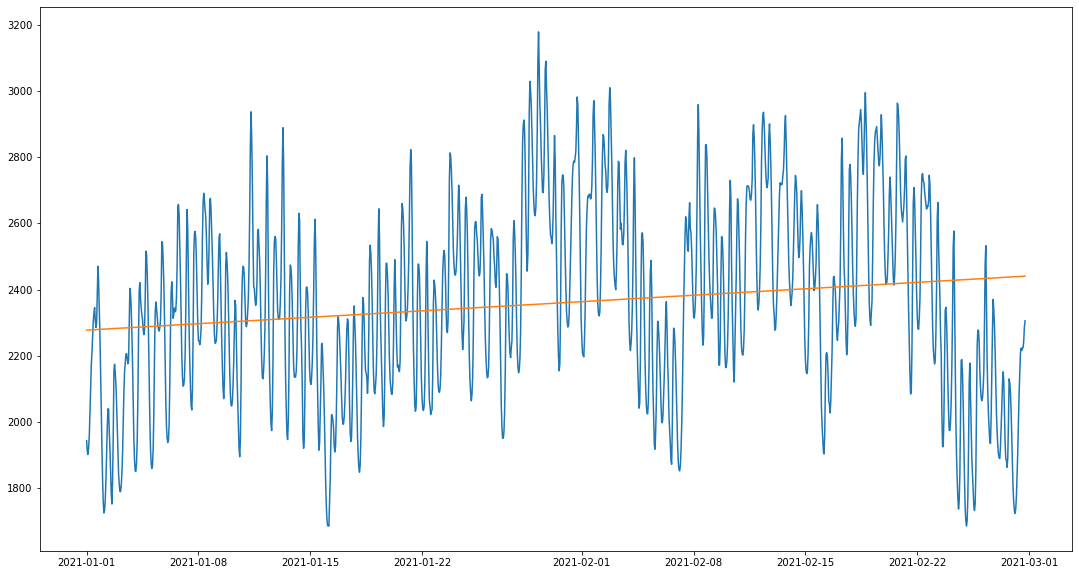

In [13]:
y_pred = reg.predict(X_timestamps)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y)
_ = ax.plot(x, y_pred)

## Fit linear regression with one-hot

In [14]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

day_of_week_1h = get_one_hot(day_of_week, 7)
month_1h = get_one_hot(month, 12)
time_of_day_1h = get_one_hot(time_of_day, 6)

X_1h = np.concatenate((day_of_week_1h,month_1h,time_of_day_1h),axis=1)

In [15]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_1h, y)
reg.score(X_1h, y)

0.21571299626164997

# Plot the fit 

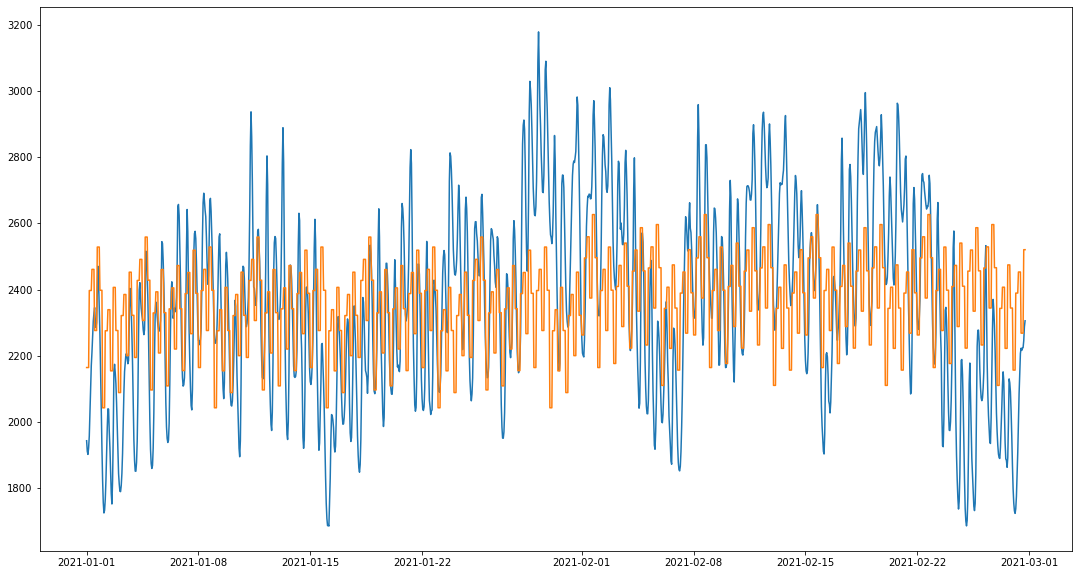

In [16]:
y_pred_1h = reg.predict(X_1h)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y)
_ = ax.plot(x, y_pred_1h)

## Fit GP vs timestamp (basically memorize the data)

In [17]:
import GPy

GPy.plotting.change_plotting_library('plotly_offline')

 /home/model/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.



# Normalization

In [18]:
# X shouldn't be particularly important with rbf/lin/brownian kernel, just get rid of crazy timestamp values

normalization_X_timestamps_min = np.min(X_timestamps)
normalization_X_timestamps_const = (6. * 10**5)

X_timestamps_normalized = (X_timestamps-normalization_X_timestamps_min)/normalization_X_timestamps_const

def normalize_single_feature(arr, arr_min, arr_max):
    return ((np.array(arr, ndmin=2) - arr_min)/(arr_max-arr_min)).T
#
# normalize to [0;1]
normalization_y_min = np.min(y)
normalization_y_max = np.max(y)

y_normalized = normalize_single_feature(y,normalization_y_min,normalization_y_max)

In [19]:
kernel_rbf = GPy.kern.RBF(input_dim=1, variance=5, lengthscale=10)
#kernel_brownian = GPy.kern.Brownian(input_dim=3, variance=10)
kernel_lin = GPy.kern.Linear(input_dim=1)
kernel = kernel_lin * kernel_rbf 

m = GPy.models.GPRegression(X_timestamps_normalized,y_normalized,kernel)

m.optimize(messages=True)
#m.optimize_restarts(num_restarts = 1)

fig = m.plot(title='1d_gp')
GPy.plotting.show(fig, filename='1d_gp')

/home/model/anaconda3/lib/python3.8/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/home/model/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:322: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.


/home/model/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


/home/model/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more spec

## Fit GP vs decomposed time features

In [21]:
normalization_day_of_week_min = np.min(day_of_week)
normalization_day_of_week_max = np.max(day_of_week)
normalization_time_of_day_min = np.min(time_of_day)
normalization_time_of_day_max = np.max(time_of_day)
X_decomp_time_features = np.concatenate((normalize_single_feature(day_of_week,
                                                                  normalization_day_of_week_min,
                                                                  normalization_day_of_week_max),
                                          normalize_single_feature(time_of_day,
                                                                  normalization_time_of_day_min,
                                                                  normalization_time_of_day_max)),axis=1) 

#X_timestamps_normalized = normalize_single_feature(time_of_day) 

# add noise
X_decomp_time_features += np.random.normal(0, 0.01, X_decomp_time_features.shape)

In [22]:
kernel_rbf = GPy.kern.RBF(input_dim=2, variance=1, lengthscale=1)
#kernel_brownian = GPy.kern.Brownian(input_dim=3, variance=10)
kernel_lin = GPy.kern.Linear(input_dim=2)
kernel = kernel_rbf * kernel_lin

m = GPy.models.GPRegression(X_decomp_time_features,y_normalized,kernel)

m.optimize(messages=True)
m.optimize_restarts(num_restarts = 3)

Optimization restart 1/3, f = -347.5538671003568
Optimization restart 2/3, f = -347.5538671142825
Optimization restart 3/3, f = -347.55386711395363


In [23]:
fig = m.plot(title='1d_gp')

GPy.plotting.show(fig, filename='1d_gp')

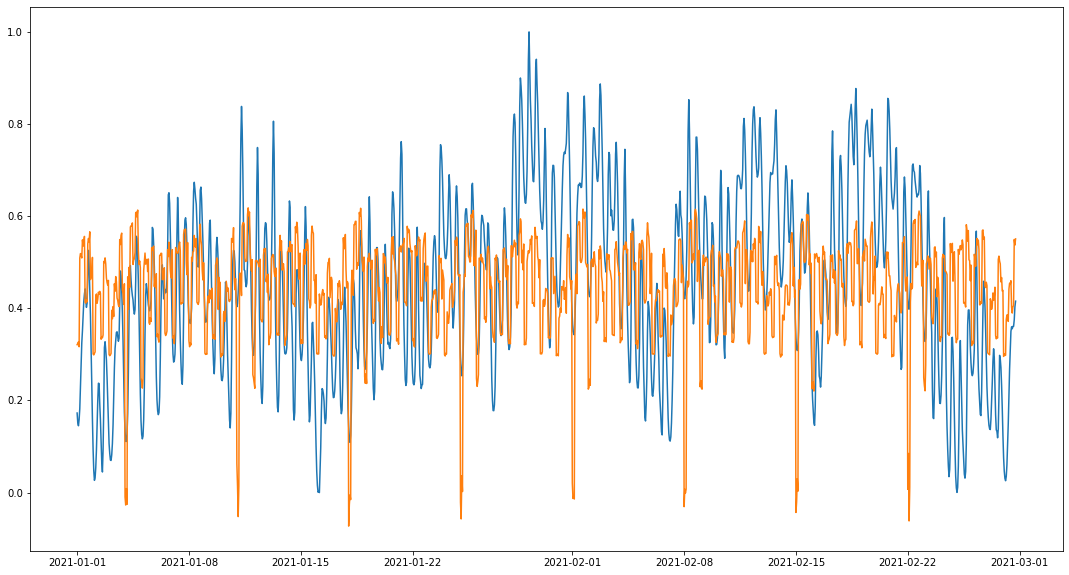

In [24]:
gp_pred = m.predict(X_decomp_time_features)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y_normalized)
_ = ax.plot(x, gp_pred[0])

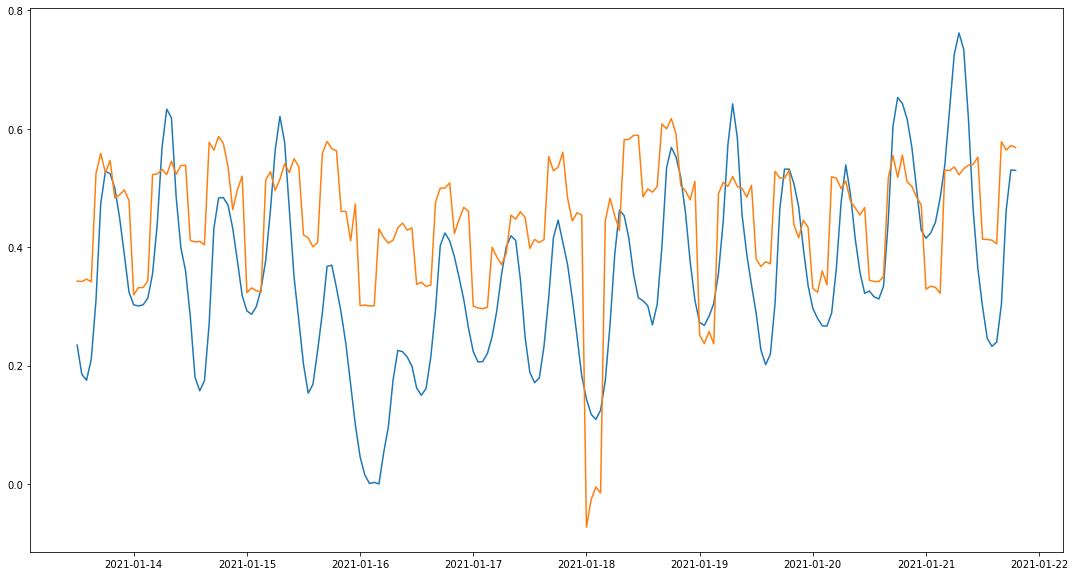

In [25]:
gp_pred = m.predict(X_decomp_time_features)

start = 300
end = 500

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x[start:end], y_normalized[start:end])
_ = ax.plot(x[start:end], gp_pred[0][start:end])

## Fit n+1 timestep model

In [26]:
X_decomp_time_and_previous_step = np.concatenate((X_decomp_time_features[1:], y_normalized[:-1]), axis=1)

y_normalized_without_first = y_normalized[1:]

In [27]:
kernel_rbf = GPy.kern.RBF(input_dim=3, variance=1, lengthscale=1)
#kernel_brownian = GPy.kern.Brownian(input_dim=3, variance=10)
kernel_lin = GPy.kern.Linear(input_dim=3)
kernel = kernel_rbf * kernel_lin

m = GPy.models.GPRegression(X_decomp_time_and_previous_step,y_normalized_without_first,kernel)

m.optimize(messages=True)
m.optimize_restarts(num_restarts = 3)

Optimization restart 1/3, f = -2485.2002734621337
Optimization restart 2/3, f = -2485.200273462813
Optimization restart 3/3, f = -2485.200273462812


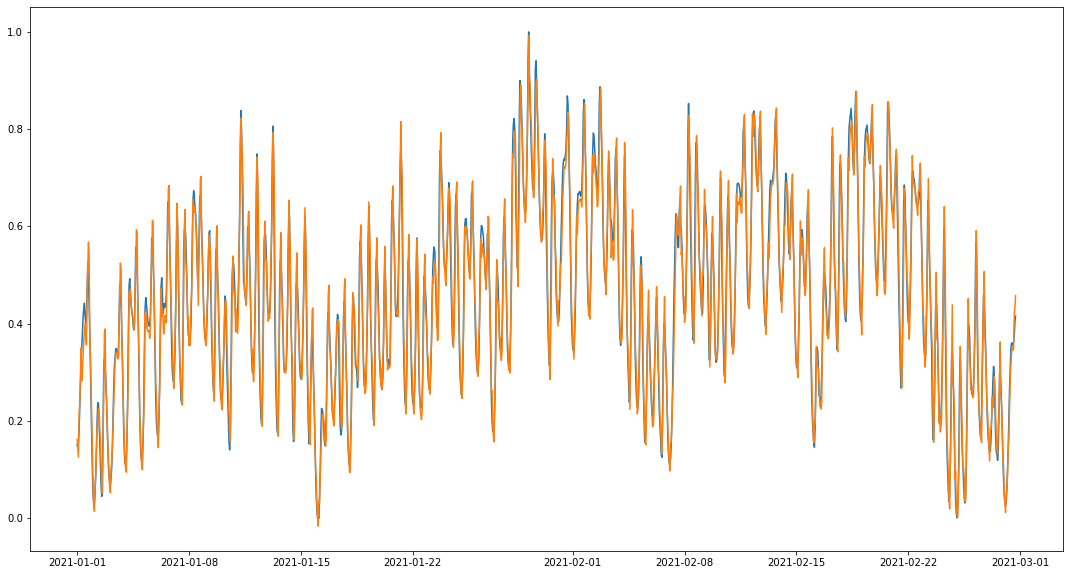

In [57]:
gp_pred = m.predict(X_decomp_time_and_previous_step)

start = 0
end = 1410

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x[start:end], y_normalized_without_first[start:end])
_ = ax.plot(x[start:end], gp_pred[0][start:end])

## Try on unseen data

In [46]:
mini_dataset = load.load_consumption_csv('./data/energy-consumption-us/mini.csv')

# convert to time, demand tuples
volume_by_timestamp_test = []
for row in mini_dataset:
    ts = row['datetime_beginning_ept'] 
    volume_by_timestamp_test.append((ts, row['mw']))
    
volume_by_timestamp_test.sort(key=lambda tup: tup[0])
x_test, y_test = zip(*volume_by_timestamp_test)

# create time features
day_of_week_test = np.array([ts.weekday() for ts in x_test])
time_of_day_test = np.array([math.floor(ts.hour / 4) for ts in x_test])  # split day into 6 periods

# construct dataset as above
X_test_decomp_time_features = np.concatenate((normalize_single_feature(day_of_week_test,
                                                                  normalization_day_of_week_min,
                                                                  normalization_day_of_week_max),
                                          normalize_single_feature(time_of_day_test,
                                                                  normalization_time_of_day_min,
                                                                  normalization_time_of_day_max)),axis=1) 


y_test_normalized = normalize_single_feature(y_test,normalization_y_min,normalization_y_max)

X_test_decomp_time_and_previous_step = np.concatenate((X_test_decomp_time_features[1:], 
                                                       y_test_normalized[:-1]), axis=1)

y_test_normalized_without_first = y_test_normalized[1:]

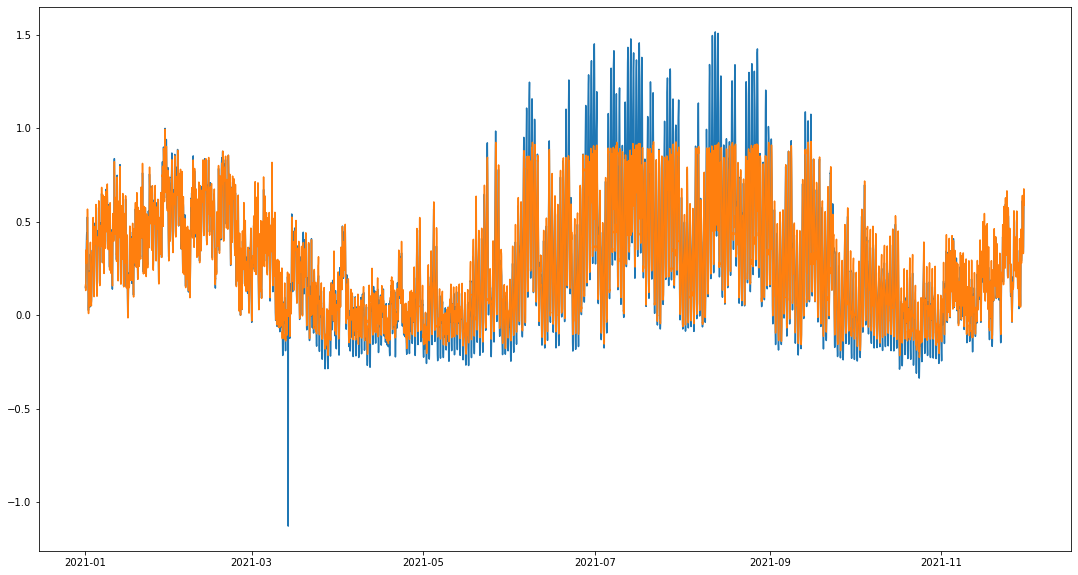

In [58]:
gp_pred_test = m.predict(X_test_decomp_time_and_previous_step)

start = 0
end = 8000

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x_test[start:end], y_test_normalized_without_first[start:end])
_ = ax.plot(x_test[start:end], gp_pred_test[0][start:end])

The model was trained on Jan and Feb, so it makes sense that it underestimates the extreme values present later in the year. Try two things:

* TODO: model change between two values instead of the absolutes
* TODO: fit model to a year or two of data and see if it picks up on seasonality
* TODO: 
